In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, InputLayer, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM
import tensorflow as tf

import preprocess, fit_nn

Data is split, training and test data has shape:
(2000, 240, 1) (2000,) (2000, 240, 1) (2000,)
Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.5011 - mean_squared_error: 1.5011 - val_loss: 0.9156 - val_mean_squared_error: 0.9156
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step - loss: 1.0584 - mean_squared_error: 1.0584 - val_loss: 0.8314 - val_mean_squared_error: 0.8314
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - loss: 1.0001 - mean_squared_error: 1.0001 - val_loss: 0.8448 - val_mean_squared_error: 0.8448
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step - loss: 1.0233 - mean_squared_error: 1.0233 - val_loss: 0.8398 - val_mean_squared_error: 0.8398
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - loss: 1.0206 - mean_squared_error: 1.0206 - val_loss: 0.8143 - val_mean_squared_error: 0.8143
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - loss: 0.9958 - mean_squared_error: 0.9958 - val_loss: 0.7841 - val_mean_squared_error: 0.7841
Epoch 7/1000
1/1 ━━━

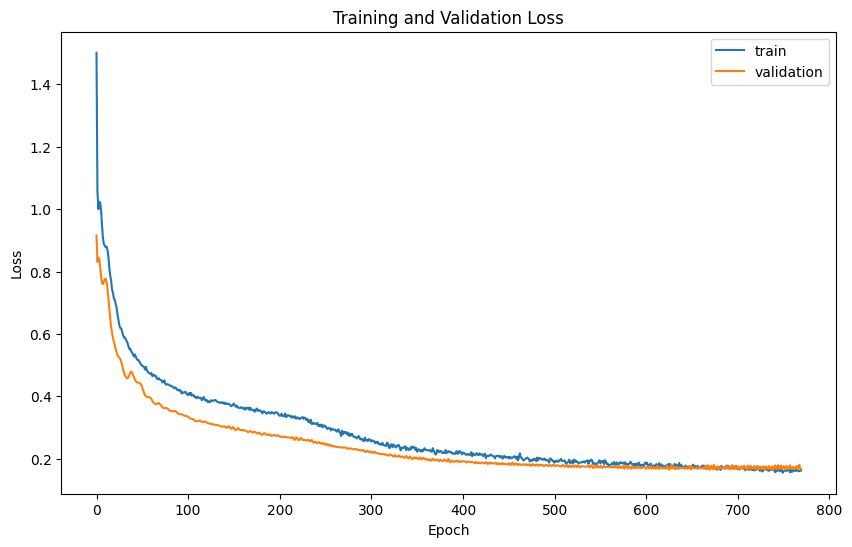

In [10]:
architecture = "LSTM_LoCap"

TL = True

source_contract = "GMMB"
source_lapse = "nolapse"
source_noiseLevel = "LowNoise"
source_dataSize = 50000

target_contract = "GMWB"
target_lapse = "nolapse"
target_noiseLevel = "LowNoise"
target_dataSize = 2000
test_size = 0
seed = 22
n_epochs = 1000
batch_size = 4096
patience = 100
lr = 0.00025
dropout = 0 
decay_rate = 0.9
layer_freeze = 0

if TL:
    source_model_path = f"./trainedModels/{source_contract}_PY/{source_lapse}/{architecture}_{source_noiseLevel}_{source_dataSize}/trained_model.keras"

    source_model = tf.keras.models.load_model(source_model_path)

    if layer_freeze > 0:
        for layer in source_model.layers[:layer_freeze]:
            layer.trainable = False
        target_model_path = f"./trainedModels/{target_contract}_PY/{target_lapse}/{architecture}_{target_noiseLevel}_{source_lapse}_{target_dataSize}_layerFreezing/"
    else:
        target_model_path = f"./trainedModels/{target_contract}_PY/{target_lapse}/{architecture}_{target_noiseLevel}_{source_lapse}_{target_dataSize}_fineTuning/"

else:

    target_model_path = f"./trainedModels/{target_contract}_PY/{target_lapse}/{architecture}_{target_noiseLevel}_{source_lapse}_{target_dataSize}/"
    cwd = f"../sim_VA/result/{target_contract}/{target_lapse}/"

    price = np.load(cwd + f"outerScenarios_{target_contract}_RS_{target_lapse}.npy")
    rtn = (price[:, 1:] - price[:, :-1]) / price[:, :-1]

    if target_noiseLevel == "LowNoise":
        N = 100
    else:
        N = 10

    substring = f"hedgingLoss_{target_contract}_RS_{N}_{target_lapse}"
    loss_file = [file for file in os.listdir(cwd) if substring in file and os.path.isfile(os.path.join(cwd, file))][0]


    X_train, y_train, X_test, y_test, y_mean, y_std = preprocess.transform_data(rtn, np.load(cwd + loss_file), True, test_size, seed,
                                                                                part=True, part_size=target_dataSize)
    
    model_name = "LSTM"
    recurrent_layer_size = [32, 4]
    dense_layer_size = 32
    activation_function = "tanh"

    source_model = fit_nn.build_model(X_train, 
                                      model_name, recurrent_layer_size, dense_layer_size, 
                                      activation_function, lr, dropout, decay_rate)


if not os.path.exists(target_model_path):
    os.makedirs(target_model_path)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                                 decay_steps=1000,
                                                                 decay_rate=decay_rate)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

source_model.compile(loss="mean_squared_error",
                     optimizer=optimizer, metrics=['mean_squared_error'])

cwd = f"../sim_VA/result/{target_contract}/{target_lapse}/"

price = np.load(cwd + f"outerScenarios_{target_contract}_RS_{target_lapse}.npy")
rtn = (price[:, 1:] - price[:, :-1]) / price[:, :-1]

substring = f"hedgingLoss_{target_contract}_RS_100_{target_lapse}"
loss_file = [file for file in os.listdir(cwd) if substring in file and os.path.isfile(os.path.join(cwd, file))][0]

X_train, y_train, X_test, y_test, y_mean, y_std = preprocess.transform_data(rtn, np.load(cwd + loss_file), True, test_size, seed,
                                                                            part=True, part_size=target_dataSize)


target_model, running_time = fit_nn.train_model(X_train, y_train, source_model, n_epochs, batch_size, patience, target_model_path)

target_model.save(target_model_path + "trained_model_1.keras")

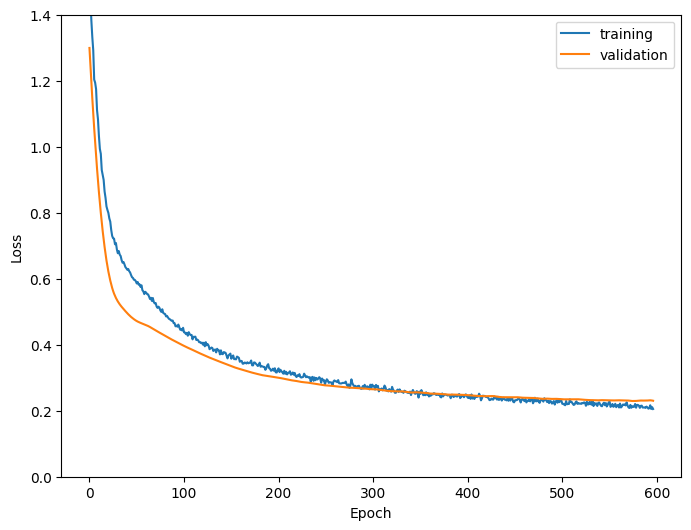

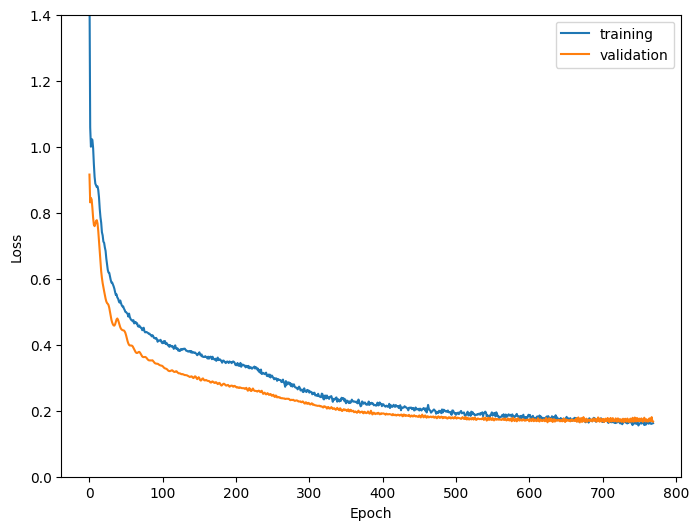

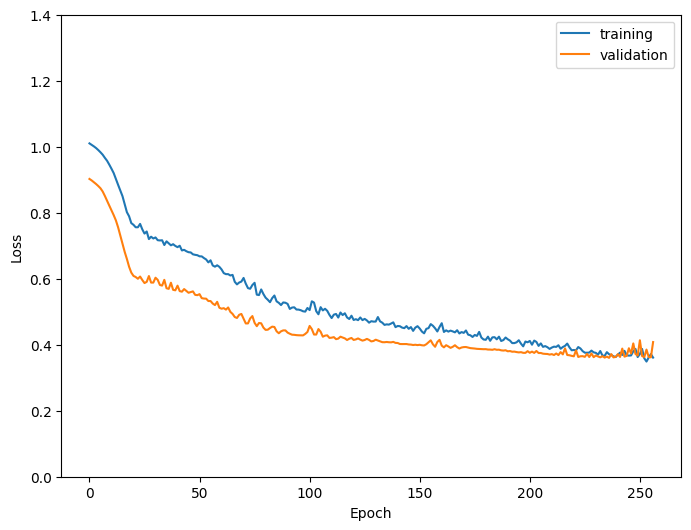

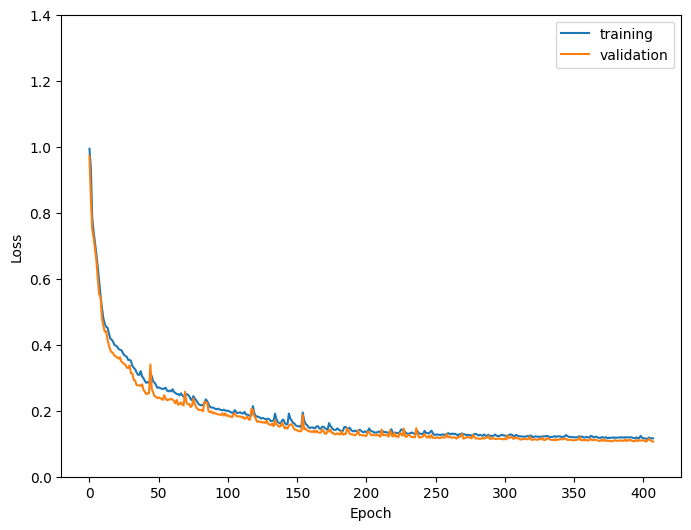

In [15]:
# load training history csv and plot

figure_path = "./figuresP3/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

history = pd.read_csv("./trainedModels/GMWB_PY/nolapse/LSTM_LoCap_LowNoise_nolapse_2000_layerFreezing/training_history.csv")
history_FT = pd.read_csv("./trainedModels/GMWB_PY/nolapse/LSTM_LoCap_LowNoise_nolapse_2000_fineTuning/training_history.csv")
history_without = pd.read_csv("./trainedModels/GMWB_PY/nolapse/LSTM_LoCap_LowNoise_nolapse_2000/training_history.csv")
history_extensive = pd.read_csv("./trainedModels/GMWB_PY/nolapse/LSTM_LoCap_LowNoise_50000/training_history.csv")

plt.figure(figsize=(8, 6))
plt.plot(history["epoch"], history["loss"], label="training")
plt.plot(history["epoch"], history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0, 1.4))
# plt.title("Layer Freezing")
plt.savefig(figure_path + "figure4d.png")


plt.figure(figsize=(8, 6))
plt.plot(history_FT["epoch"], history_FT["loss"], label="training")
plt.plot(history_FT["epoch"], history_FT["val_loss"], label="validation")
plt.legend()
plt.ylim((0, 1.4))
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title("Fine Tuning")
plt.savefig(figure_path + "figure4c.png")

plt.figure(figsize=(8, 6))
plt.plot(history_without["epoch"], history_without["loss"], label="training")
plt.plot(history_without["epoch"], history_without["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0, 1.4))
# plt.title("Without Transfer Learning")
plt.savefig(figure_path + "figure4b.png")

plt.figure(figsize=(8, 6))
plt.plot(history_extensive["epoch"], history_extensive["loss"], label="training")
plt.plot(history_extensive["epoch"], history_extensive["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0, 1.4))
# plt.title("Extensive Training")
plt.savefig(figure_path + "figure4a.png")


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, InputLayer, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM
import tensorflow as tf

import preprocess, fit_nn

target_contract = "GMWB"
target_lapse = "nolapse"
target_noiseLevel = "LowNoise"
target_dataSize = 2000
test_size = 0
seed = 22
n_epochs = 1000
batch_size = 4096
patience = 100
lr = 0.00025
dropout = 0 
decay_rate = 0.9
layer_freeze = 0

cwd = f"../sim_VA/result/{target_contract}/{target_lapse}/"

price = np.load(cwd + f"outerScenarios_{target_contract}_RS_{target_lapse}.npy")
rtn = (price[:, 1:] - price[:, :-1]) / price[:, :-1]

substring = f"hedgingLoss_{target_contract}_RS_100_{target_lapse}"
loss_file = [file for file in os.listdir(cwd) if substring in file and os.path.isfile(os.path.join(cwd, file))][0]

X_train, y_train, X_test, y_test, y_mean, y_std = preprocess.transform_data(rtn, np.load(cwd + loss_file), True, test_size, seed,
                                                                            part=True, part_size=target_dataSize)


model_WO = tf.keras.models.load_model("./trainedModels/GMWB_PY/nolapse/LSTM_LoCap_LowNoise_nolapse_2000/trained_model.keras")
model_FT = tf.keras.models.load_model("./trainedModels/GMWB_PY/nolapse/LSTM_LoCap_LowNoise_nolapse_2000_fineTuning/trained_model.keras")
model_LF = tf.keras.models.load_model("./trainedModels/GMWB_PY/nolapse/LSTM_LoCap_LowNoise_nolapse_2000_layerFreezing/trained_model.keras")
model_EX = tf.keras.models.load_model("./trainedModels/GMWB_PY/nolapse/LSTM_LoCap_LowNoise_50000/trained_model.keras")

Price = np.load(cwd + "outerScenarios_GMWB_RS_nolapse.npy")
Loss_true = np.load(cwd + "hedgingLoss_GMWB_RS_10000_nolapse.npy")
Return_true = (Price[:, 1:] - Price[:, :-1]) / Price[:, :-1]

X_true, y_true = preprocess.transform_data(Return_true, Loss_true, False, test_size, seed, 
                                                       y_mean=y_mean, y_std=y_std)

y_true = y_true.flatten()

y_WO = model_WO.predict(X_true).flatten()
y_FT = model_FT.predict(X_true).flatten()
y_LF = model_LF.predict(X_true).flatten()
y_EX = model_EX.predict(X_true).flatten()

mse_WO = np.mean((y_true - y_WO) ** 2)
mse_FT = np.mean((y_true - y_FT) ** 2)
mse_LF = np.mean((y_true - y_LF) ** 2)
mse_EX = np.mean((y_true - y_EX) ** 2)

print(f"MSE without transfer learning: {mse_WO}")
print(f"MSE fine tuning: {mse_FT}")
print(f"MSE layer freezing: {mse_LF}")
print(f"MSE extensive training: {mse_EX}")

Data is split, training and test data has shape:
(2000, 240, 1) (2000,) (2000, 240, 1) (2000,)
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step
MSE without transfer learning: 0.41877936629876306
MSE fine tuning: 0.17804821670582505
MSE layer freezing: 0.22948101130197762
MSE extensive training: 0.07260361812790325


In [4]:
y_WO_train = model_WO.predict(X_train).flatten()
y_FT_train = model_FT.predict(X_train).flatten()
y_LF_train = model_LF.predict(X_train).flatten()
y_EX_train = model_EX.predict(X_train).flatten()

mse_WO_train = np.mean((y_train - y_WO_train) ** 2)
mse_FT_train = np.mean((y_train - y_FT_train) ** 2)
mse_LF_train = np.mean((y_train - y_LF_train) ** 2)
mse_EX_train = np.mean((y_train - y_EX_train) ** 2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [10]:
# Latex table
df = pd.DataFrame({"Model": ["Without TL", "Fine Tuning", "Layer Freezing", "Extensive Training"],
                   "Training MSE": [mse_WO_train, mse_FT_train, mse_LF_train, mse_EX_train],
                     "True MSE": [mse_WO, mse_FT, mse_LF, mse_EX]})
df.set_index("Model", inplace=True)
df.to_latex("table4.tex")